In [21]:
!pip3 install arviz
import arviz as az

!pip3 install numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import print_summary
import numpyro.optim as optim
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, NUTS, MCMC
from numpyro.infer.autoguide import AutoLaplaceApproximation
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap, jacfwd, jacrev
from jax.random import PRNGKey as PK

import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load and stdize data

In [22]:
d = pd.read_csv('https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Howell1.csv', delimiter=';')
print(d.info())
d.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB
None


,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [23]:
ad = d['age'] >= 18
stdize = lambda x: ((x - x.mean())/ x.std()).to_numpy()
A = stdize(d['age'][ad])
H = stdize(d['height'][ad])
W = stdize(d['weight'][ad])
S = d['male'][ad].to_numpy()

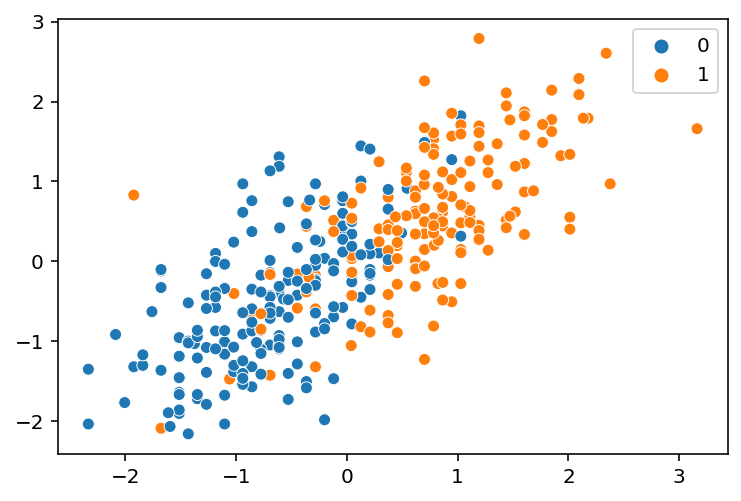

In [24]:
sns.scatterplot(x=H,y=W,hue=S)

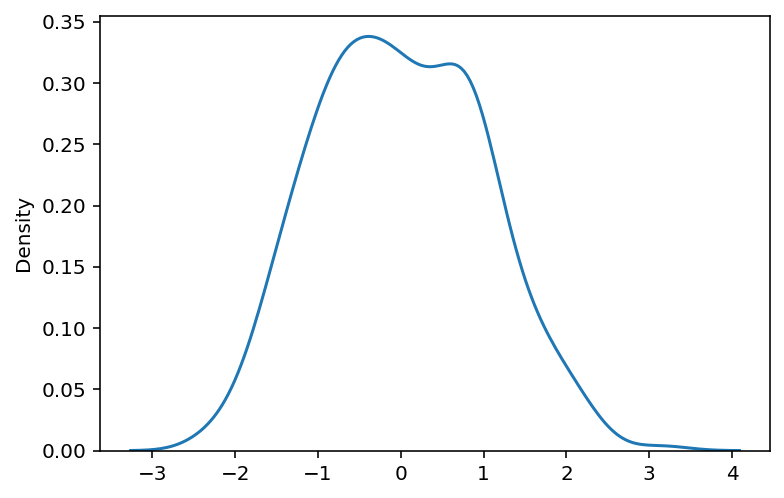

In [25]:
sns.kdeplot(H)

# NUTS vs SVI

In [26]:
?Predictive

In [27]:
d2 = d[ad]
hbar = d2['height'].mean()
print(hbar)

154.5970926136364


In [28]:
def model(h=None):
    mu = numpyro.sample('mu', dist.Normal(178, 20))
    sigma = numpyro.sample('sigma', dist.Uniform(0, 50))
    height = numpyro.sample('height', dist.Normal(mu, sigma), obs=h)

In [29]:
msvi = AutoLaplaceApproximation(model)
svi = SVI(model, msvi, optim.Adam(1), Trace_ELBO(), h=d2.height.values)
svi_result = svi.run(PK(0), 2000)
psvi = svi_result.params

100%|██████████| 2000/2000 [00:01<00:00, 1188.28it/s, init loss: 4000.1155, avg. loss [1901-2000]: 1226.0389]


In [30]:
samples = msvi.sample_posterior(PK(1), psvi, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    154.00    155.28    995.05      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.15      1.00



In [31]:
nuts = NUTS(model)
mcmc = MCMC(nuts,  num_warmup=500, num_samples=3000, num_chains=4)
mcmc.run(PK(0), h=d2.height.values)
mcmcs = mcmc.get_samples()

<ipython-input-31-5f3c8a265987>:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts,  num_warmup=500, num_samples=3000, num_chains=4)
sample: 100%|██████████| 3500/3500 [00:06<00:00, 580.91it/s, 3 steps of size 1.05e+00. acc. prob=0.87]


In [32]:
print_summary(mcmcs, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.61      0.41    154.60    153.95    155.27  10885.61      1.00
     sigma      7.77      0.29      7.76      7.30      8.23  12529.01      1.00



In [33]:
idata = az.from_numpyro(mcmc)
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e9f057340>,
      dtype=object)

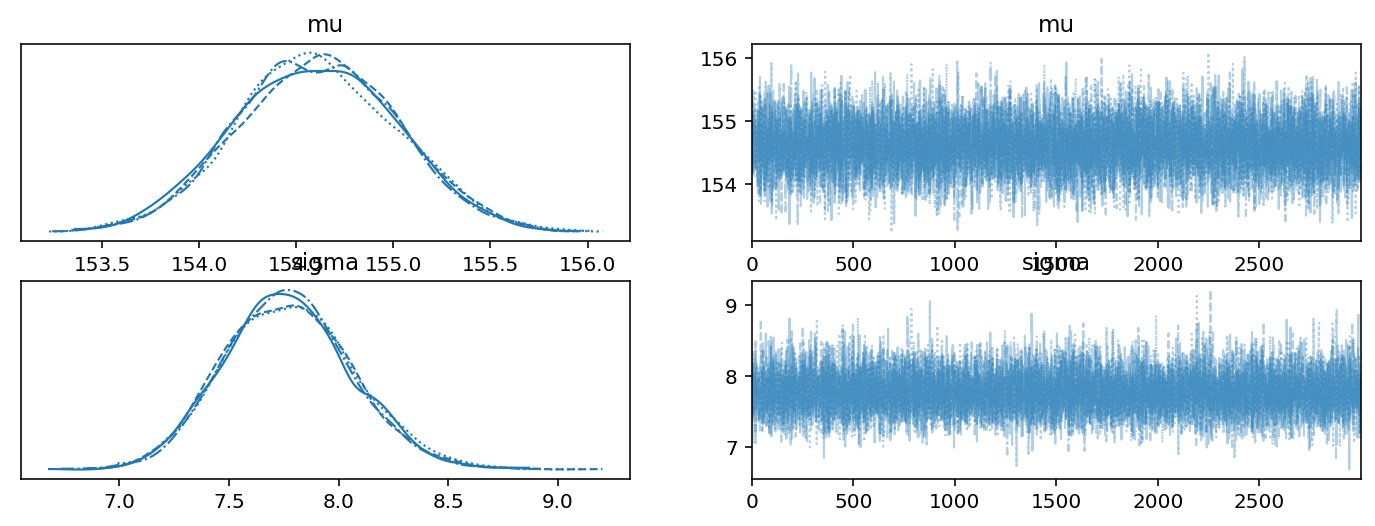

In [34]:
az.plot_trace(idata)

In [35]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.606,0.415,153.841,155.389,0.004,0.003,10997.0,8156.0,1.0
sigma,7.771,0.293,7.209,8.298,0.003,0.002,12696.0,8459.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e9ed6c550>,
      dtype=object)

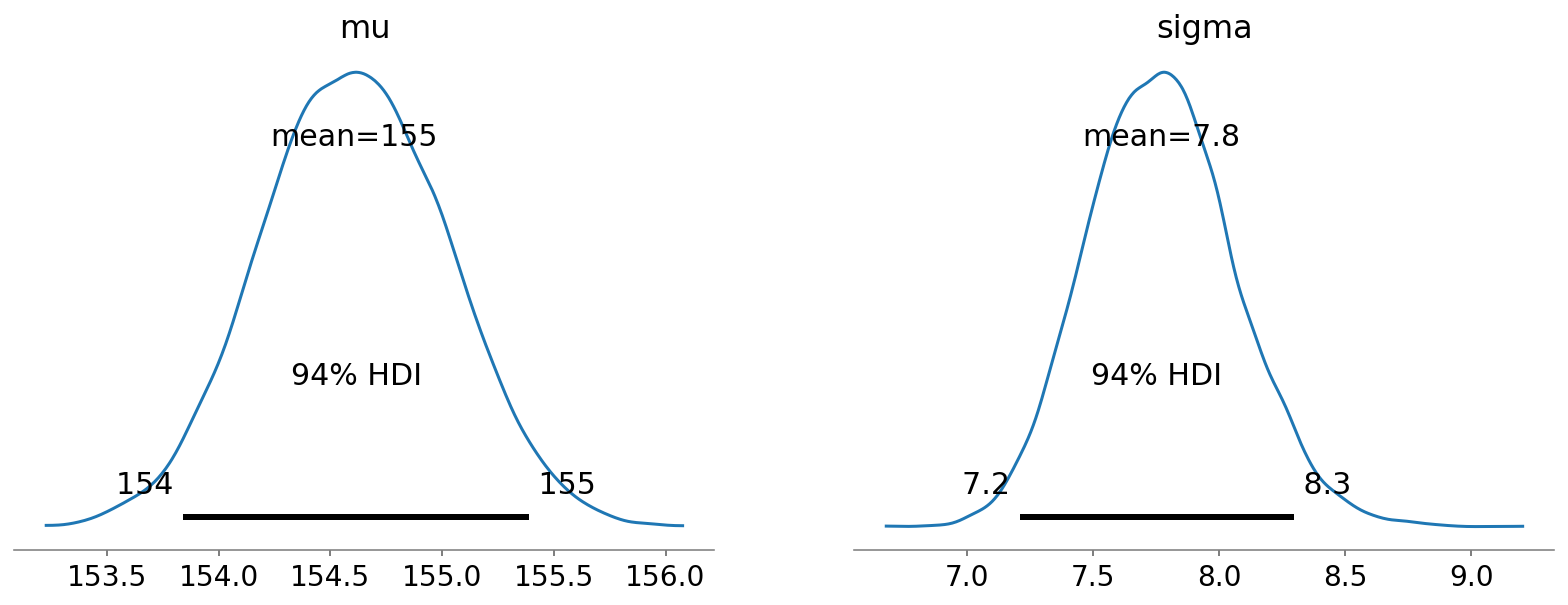

In [36]:
az.plot_posterior(idata)

# FULL LUXURY BAYES

In [38]:
, numpy
def FLBM(H=None, S=None, W=None):
    tau = numpyro.sample('tau', dist.Uniform(0, 10))
    nu = numpyro.sample('nu', dist.Normal(160, 10), sample_shape=(2,))
    height = numpyro.sample('height', dist.Normal(nu[S], tau), obs=H)

    sigma = numpyro.sample('sigma', dist.Uniform(0, 10))
    a = numpyro.sample('a', dist.Normal(60, 10), sample_shape=(2,))
    b = numpyro.sample('b', dist.Uniform(0, 1), sample_shape=(2,))
    mu = a[S] + b[S] * (height - hbar)
    numpyro.sample('weight', dist.Normal(mu, sigma), obs=W)

In [40]:
mcmc = MCMC(NUTS(FLBM),  num_warmup=500, num_samples=3000, num_chains=4)
mcmc.run(PK(0), H=d2.height.values, S=d2.male.values, W=d2.weight.values)
PSmcmc = mcmc.get_samples()

<ipython-input-40-92edb7b2fc21>:1: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(FLBM),  num_warmup=500, num_samples=3000, num_chains=4)
sample: 100%|██████████| 3500/3500 [00:05<00:00, 655.57it/s, 7 steps of size 5.11e-01. acc. prob=0.90]


In [42]:
d2.male

0      1
1      0
2      0
3      1
4      0
      ..
534    0
537    0
540    1
541    0
543    1
Name: male, Length: 352, dtype: int64